In [9]:
import pandas as pd
from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
from datasets import Dataset

In [10]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize(batch):
    return tokenizer(batch['kk_clean_text'], padding=True, truncation=True)


In [11]:
df = pd.read_csv('../data/processed/kazakh_cleaned_bit.csv')
df = df[['kk_clean_text', 'has_toxicity']]  
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   kk_clean_text  2463 non-null   object
 1   has_toxicity   2463 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.6+ KB


In [12]:
# Rename label column before converting to HF Dataset
df = df.rename(columns={'has_toxicity': 'labels'}) 


In [13]:
dataset = Dataset.from_pandas(df)
dataset = dataset.map(tokenize, batched=True)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Split into train/test
split = dataset.train_test_split(test_size=0.2)

Map: 100%|██████████| 2463/2463 [00:00<00:00, 10706.89 examples/s]


In [14]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    logging_dir="./logs",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split['train'],
    eval_dataset=split['test']
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.705300
1000,0.697700


TrainOutput(global_step=1479, training_loss=0.6994959255422266, metrics={'train_runtime': 570.0817, 'train_samples_per_second': 10.367, 'train_steps_per_second': 2.594, 'total_flos': 1554986337177600.0, 'train_loss': 0.6994959255422266, 'epoch': 3.0})

In [15]:
trainer.evaluate()

{'eval_loss': 0.6930663585662842,
 'eval_runtime': 15.0631,
 'eval_samples_per_second': 32.729,
 'eval_steps_per_second': 8.232,
 'epoch': 3.0}

In [16]:
predictions = trainer.predict(split["test"])

In [17]:
from sklearn.metrics import classification_report
import numpy as np

y_true = split["test"]["labels"]
y_pred = np.argmax(predictions.predictions, axis=1)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       246
           1       0.00      0.00      0.00       247

    accuracy                           0.50       493
   macro avg       0.25      0.50      0.33       493
weighted avg       0.25      0.50      0.33       493



/Users/nuradilserik/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nuradilserik/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nuradilserik/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

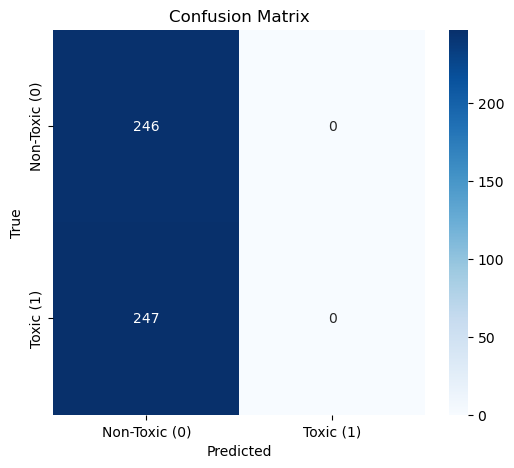

               precision    recall  f1-score   support

Non-Toxic (0)       0.50      1.00      0.67       246
    Toxic (1)       0.00      0.00      0.00       247

     accuracy                           0.50       493
    macro avg       0.25      0.50      0.33       493
 weighted avg       0.25      0.50      0.33       493



/Users/nuradilserik/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nuradilserik/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nuradilserik/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Predictions and true labels
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = split["test"]["labels"]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ["Non-Toxic (0)", "Toxic (1)"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=labels))

en version

In [20]:
from transformers import BertForSequenceClassification, BertTokenizerFast
import torch

model = BertForSequenceClassification.from_pretrained("../models/final_model")
tokenizer = BertTokenizerFast.from_pretrained("../models/final_model")

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    return probs[0].tolist()

# Example
text = "gay"
print(predict(text))

[0.0003644420357886702, 0.9996355772018433]
